# Sentiment Analysis Model Training
Notebook untuk training model analisis sentimen ulasan aplikasi Gojek

## 1. Import Library
Import semua library yang diperlukan

In [1]:
%pip install numpy pandas scikit-learn gensim tensorflow sastrawi

  Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl.metadata (4.1 kB)
  Using cached Sastrawi-1.0.1-py2.py3-none-any.whl.metadata (909 bytes)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.4-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached ter

In [2]:
import pandas as pd
import numpy as np
import re
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

## 2. Load and prepare data
Memuat dan menyiapkan data untuk training

In [3]:
df = pd.read_csv('./DATA/GojekAppReview_1.csv')

# Sentiment labeling
def label_sentiment(score):
    if score <= 2: return 'negative'
    elif score == 3: return 'neutral'
    else: return 'positive'

df['sentiment'] = df['score'].apply(label_sentiment)

## 3. Text Preprocessing
Melakukan preprocessing terhadap dataset

In [4]:
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()
stemmer = StemmerFactory().create_stemmer()

normalization_dict = {
    # Basic conversions
    "gk": "gak", "ga": "gak", "tdk": "tidak", "bgt": "banget", "dr": "dari",
    "udh": "sudah", "jg": "juga", "aja": "saja", "sy": "saya", "trs": "terus",
    "ngga": "tidak", "nggak": "tidak", "bkin": "bikin", "blm": "belum",
    "sm": "sama", "tp": "tapi", "dgn": "dengan", "krn": "karena",
    
    # Additional common Indonesian slang words
    "yg": "yang", "utk": "untuk", "dg": "dengan", "klo": "kalau", "kok": "kok",
    "gw": "saya", "gue": "saya", "lu": "kamu", "kyk": "seperti", "gmn": "bagaimana",
    "sih": "sih", "deh": "deh", "dpt": "dapat", "bs": "bisa", "sdh": "sudah",
    "ttg": "tentang", "dlm": "dalam", "kl": "kalau", "km": "kamu", "hrs": "harus",
    "mk": "maka", "scr": "secara", "spy": "supaya", "bnyk": "banyak", "slh": "salah",
    "krna": "karena", "mw": "mau", "pk": "pakai", "pke": "pakai", "tq": "terima kasih",
    "thx": "terima kasih", "gpp": "tidak apa-apa", "gampng": "gampang", "bwt": "buat",
    "skrng": "sekarang", "skrg": "sekarang", "msh": "masih", "bnr": "benar",
    "trims": "terima kasih", "gk": "tidak", "gak": "tidak", "udah": "sudah",
    "pgen": "ingin", "pgn": "ingin", "kyk": "seperti", "gitu": "begitu",
    "gini": "begini", "gmana": "bagaimana", "gimana": "bagaimana", "gt": "begitu",
    "yah": "ya", "karna": "karena", "dri": "dari", "tdk": "tidak",
    "knp": "kenapa", "kpn": "kapan", "nih": "ini", "spt": "seperti",
    "ntaps": "mantap", "mantul": "mantap", "mantap": "mantap"
}

def preprocess_text(text):
    text = re.sub(r'[^\\w\\s]', '', str(text).lower().strip())
    words = text.split()
    normalized_words = [normalization_dict.get(word, word) for word in words]
    text = ' '.join(normalized_words)
    text = stemmer.stem(text)
    text = stopword.remove(text)
    return text

df['clean_content'] = df['content'].apply(preprocess_text)

## 4. Train-test Split
Memisahkan data untuk training dan data untuk testing

In [5]:
X = df['clean_content']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. Traditional ML Model SVM with TF-IDF
Melakukan training model machine learning traditional SVM menggunakan TF-IDF

In [6]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_tfidf, y_train)

y_pred_svm = svm_model.predict(X_test_tfidf)
print("SVM Performance:")
print(classification_report(y_test, y_pred_svm))

# Save traditional model
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

SVM Performance:
              precision    recall  f1-score   support

    negative       0.61      0.40      0.48     10897
     neutral       0.00      0.00      0.00      1874
    positive       0.79      0.93      0.86     32230

    accuracy                           0.76     45001
   macro avg       0.47      0.44      0.45     45001
weighted avg       0.72      0.76      0.73     45001



['tfidf_vectorizer.pkl']

## 6. Deep Learning Model LSTM with Word2Vec
Melakukan training model LSTM dengan Word2Vec

In [7]:
# Word2Vec embeddings
sentences = [text.split() for text in X_train]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Label encoding
label_dict = {'negative': 0, 'neutral': 1, 'positive': 2}
y_train_num = y_train.map(label_dict)
y_test_num = y_test.map(label_dict)

# LSTM model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=100, input_length=max_len))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Train model
history = model.fit(X_train_pad, y_train_num,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_test_pad, y_test_num))

# Evaluate
y_pred_lstm = model.predict(X_test_pad)
y_pred_lstm = np.argmax(y_pred_lstm, axis=1)
print("LSTM Performance:")
print(classification_report(y_test_num, y_pred_lstm))

# Save deep learning model
model.save('lstm_model.h5')
joblib.dump(tokenizer, 'tokenizer.pkl')

c:\Users\bimag\OneDrive\文档\PK UAS\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 338s 119ms/step - accuracy: 0.7587 - loss: 0.6122 - val_accuracy: 0.7666 - val_loss: 0.6024
Epoch 2/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 328s 117ms/step - accuracy: 0.7697 - loss: 0.5890 - val_accuracy: 0.7659 - val_loss: 0.6021
Epoch 3/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 363s 129ms/step - accuracy: 0.7707 - loss: 0.5895 - val_accuracy: 0.7662 - val_loss: 0.6040
Epoch 4/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 670s 238ms/step - accuracy: 0.7727 - loss: 0.5824 - val_accuracy: 0.7653 - val_loss: 0.6020
Epoch 5/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 333s 119ms/step - accuracy: 0.7731 - loss: 0.5821 - val_accuracy: 0.7658 - val_loss: 0.6025
Epoch 6/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 385s 137ms/step - accuracy: 0.7744 - loss: 0.5793 - val_accuracy: 0.7660 - val_loss: 0.6027
Epoch 7/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 418s 149ms/step - accuracy: 0.7711 - loss: 0.5870 - val_accuracy: 0.7626 - val_loss: 0.6043
Epoch 8/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 477s 170ms/step - ac

LSTM Performance:
              precision    recall  f1-score   support

           0       0.61      0.41      0.49     10897
           1       0.33      0.00      0.00      1874
           2       0.80      0.93      0.86     32230

    accuracy                           0.77     45001
   macro avg       0.58      0.45      0.45     45001
weighted avg       0.73      0.77      0.73     45001



['tokenizer.pkl']

## 7. Evaluate Model and Inference
Memplotting evaluasi dari model SVM dan LSTM dan melakukan inferensi

In [8]:
%pip install matplotlib seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------- ----------------------------- 2.1/8.1 MB 11.7 MB/s eta 0:00:01
   ------------------------ --------------- 5.0/8.1 MB 13.7 MB/s eta 0:00:01
   ---------------------------------------  7.9/8.1 MB 13.9 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 13.5 MB/s eta 0:00:00
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 11.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 12.9 MB/s eta 0:00:00
Using cached pyparsing-3.2.3-

SVM Classification Report:
              precision    recall  f1-score   support

    negative       0.61      0.41      0.49     54171
     neutral       0.61      0.00      0.00      9460
    positive       0.80      0.93      0.86    161371

    accuracy                           0.77    225002
   macro avg       0.67      0.45      0.45    225002
weighted avg       0.74      0.77      0.73    225002



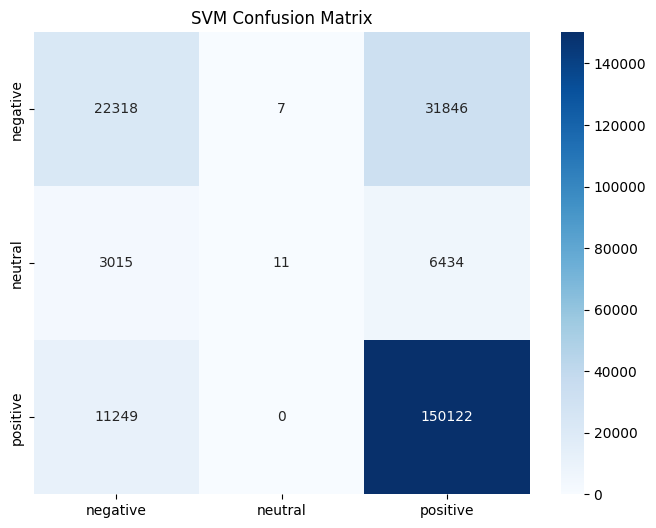

7032/7032 ━━━━━━━━━━━━━━━━━━━━ 159s 23ms/step

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.43      0.51     54171
           1       0.94      0.01      0.02      9460
           2       0.80      0.93      0.86    161371

    accuracy                           0.77    225002
   macro avg       0.79      0.46      0.47    225002
weighted avg       0.77      0.77      0.74    225002



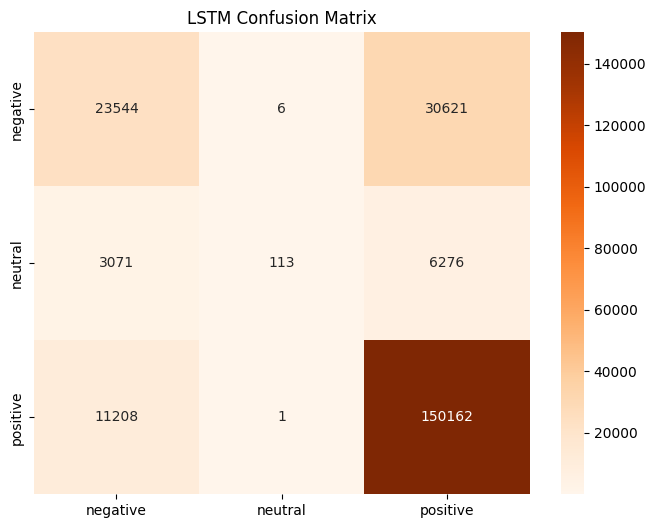

Input: Driver sangat ramah dan membantu

SVM Results:
Prediction: positive
Confidence: 79.09%

LSTM Results:
Prediction: positive
Confidence: 84.67%
Input: Aplikasi sering crash saat dipakai

SVM Results:
Prediction: positive
Confidence: 79.09%

LSTM Results:
Prediction: positive
Confidence: 50.17%
Input: Cukup memuaskan tapi harganya mahal

SVM Results:
Prediction: positive
Confidence: 79.09%

LSTM Results:
Prediction: positive
Confidence: 84.67%


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Load semua model dan komponen preprocessing
def load_models():
    # Load model SVM dan TF-IDF
    svm_model = joblib.load('./Model/SVM/svm_model.pkl')
    tfidf = joblib.load('./Model/SVM/tfidf_vectorizer.pkl')
    
    # Load model LSTM dan tokenizer
    lstm_model = load_model('./Model/LSTM/lstm_model.h5')
    tokenizer = joblib.load('./Model/LSTM/tokenizer.pkl')
    
    return svm_model, tfidf, lstm_model, tokenizer

# 2. Load test data (asumsi sudah ada X_test dan y_test)
# Sesuaikan dengan path dataset Anda
df = pd.read_csv('./DATA/GojekAppReview_1.csv')
df['sentiment'] = df['score'].apply(lambda x: 'negative' if x <= 2 else 'neutral' if x == 3 else 'positive')
df['clean_content'] = df['content'].apply(preprocess_text)  # Gunakan fungsi preprocessing yang sama

X_test = df['clean_content']
y_test = df['sentiment']

# 3. Load model dan komponen
svm_model, tfidf, lstm_model, tokenizer = load_models()

# 4. Fungsi evaluasi untuk SVM
def evaluate_svm():
    X_test_tfidf = tfidf.transform(X_test)
    y_pred = svm_model.predict(X_test_tfidf)
    
    print("SVM Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['negative', 'neutral', 'positive'],
                yticklabels=['negative', 'neutral', 'positive'])
    plt.title('SVM Confusion Matrix')
    plt.show()

# 5. Fungsi evaluasi untuk LSTM
def evaluate_lstm():
    # Tokenisasi dan padding
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    X_test_pad = pad_sequences(X_test_seq, maxlen=100)
    
    # Konversi label ke numerik
    label_dict = {'negative':0, 'neutral':1, 'positive':2}
    y_test_num = y_test.map(label_dict)
    
    # Prediksi
    y_pred = np.argmax(lstm_model.predict(X_test_pad), axis=1)
    
    print("\nLSTM Classification Report:")
    print(classification_report(y_test_num, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_num, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=['negative', 'neutral', 'positive'],
                yticklabels=['negative', 'neutral', 'positive'])
    plt.title('LSTM Confusion Matrix')
    plt.show()

# 6. Jalankan evaluasi
evaluate_svm()
evaluate_lstm()

# 7. Fungsi inferensi dengan confidence
def predict_sentiment(text):
    # Preprocessing
    cleaned_text = preprocess_text(text)
    
    # SVM Prediction
    svm_input = tfidf.transform([cleaned_text])
    svm_proba = svm_model.predict_proba(svm_input)[0]
    svm_pred = svm_model.predict(svm_input)[0]
    
    # LSTM Prediction
    lstm_input = tokenizer.texts_to_sequences([cleaned_text])
    lstm_input = pad_sequences(lstm_input, maxlen=100)
    lstm_proba = lstm_model.predict(lstm_input, verbose=0)[0]
    lstm_pred = np.argmax(lstm_proba)
    label_dict = {0:'negative', 1:'neutral', 2:'positive'}
    
    # Format output
    print(f"Input: {text}")
    print("\nSVM Results:")
    print(f"Prediction: {svm_pred}")
    print(f"Confidence: {max(svm_proba)*100:.2f}%")
    print("\nLSTM Results:")
    print(f"Prediction: {label_dict[lstm_pred]}")
    print(f"Confidence: {max(lstm_proba)*100:.2f}%")
    print("="*50)

# 8. Contoh penggunaan
test_samples = [
    "Driver sangat ramah dan membantu",
    "Aplikasi sering crash saat dipakai",
    "Cukup memuaskan tapi harganya mahal"
]

for text in test_samples:
    predict_sentiment(text)

In [32]:
# 7. Fungsi inferensi dengan confidence
def predict_sentiment(text):
    # Preprocessing
    cleaned_text = preprocess_text(text)
    
    # SVM Prediction
    svm_input = tfidf.transform([cleaned_text])
    svm_proba = svm_model.predict_proba(svm_input)[0]
    svm_pred = svm_model.predict(svm_input)[0]
    
    # LSTM Prediction
    lstm_input = tokenizer.texts_to_sequences([cleaned_text])
    lstm_input = pad_sequences(lstm_input, maxlen=100)
    lstm_proba = lstm_model.predict(lstm_input, verbose=0)[0]
    lstm_pred = np.argmax(lstm_proba)
    label_dict = {0:'negative', 1:'neutral', 2:'positive'}
    
    # Format output
    print(f"Input: {text}")
    print("\nSVM Results:")
    print(f"Prediction: {svm_pred}")
    print(f"Confidence: {max(svm_proba)*100:.2f}%")
    print("\nDetail:")
    print(f"Negative Conf: {svm_proba[0]*100:.2f}%")
    print(f"Neutral Conf: {svm_proba[1]*100:.2f}%")
    print(f"Positive Conf: {svm_proba[2]*100:.2f}%")
    print("\nLSTM Results:")
    print(f"Prediction: {label_dict[lstm_pred]}")
    print(f"Confidence: {max(lstm_proba)*100:.2f}%")
    print("\nDetail:")
    print(f"Negative Conf: {lstm_proba[0]*100:.2f}%")
    print(f"Neutral Conf: {lstm_proba[1]*100:.2f}%")
    print(f"Positive Conf: {lstm_proba[2]*100:.2f}%")
    print("="*50)

# 8. Contoh penggunaan
test_samples = [
    "akun gopay saya di blok",
    "Driver sangat tidak ramah dan tidak membantu",
    "Cukup memuaskan tapi harganya mahal"
]

for text in test_samples:
    predict_sentiment(text)

Input: akun gopay saya di blok

SVM Results:
Prediction: positive
Confidence: 79.09%

Detail:
Negative Conf: 17.01%
Neutral Conf: 3.90%
Positive Conf: 79.09%

LSTM Results:
Prediction: positive
Confidence: 84.67%

Detail:
Negative Conf: 12.52%
Neutral Conf: 2.81%
Positive Conf: 84.67%
Input: Driver sangat tidak ramah dan tidak membantu

SVM Results:
Prediction: positive
Confidence: 79.09%

Detail:
Negative Conf: 17.01%
Neutral Conf: 3.90%
Positive Conf: 79.09%

LSTM Results:
Prediction: positive
Confidence: 84.67%

Detail:
Negative Conf: 12.52%
Neutral Conf: 2.81%
Positive Conf: 84.67%
Input: Cukup memuaskan tapi harganya mahal

SVM Results:
Prediction: positive
Confidence: 79.09%

Detail:
Negative Conf: 17.01%
Neutral Conf: 3.90%
Positive Conf: 79.09%

LSTM Results:
Prediction: positive
Confidence: 84.67%

Detail:
Negative Conf: 12.52%
Neutral Conf: 2.81%
Positive Conf: 84.67%
